In [1]:
import scipy
import scipy.io
import scipy.ndimage
import numpy as np
from scipy.sparse.linalg import spsolve
from scipy import sparse
from scipy.linalg import block_diag
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch
import pickle
from functools import partial

# from NeuralNet import *
from timeit import default_timer

from Solver import *
import sys
sys.path.append('../Utility')
import PlotDefault
import NeuralNet
import KalmanInversion 
from Numerics import interpolate_f2c, gradient_first_f2c
# import imp
# imp.reload(KalmanInversion )
# imp.reload(NeuralNet )


# Load Training data

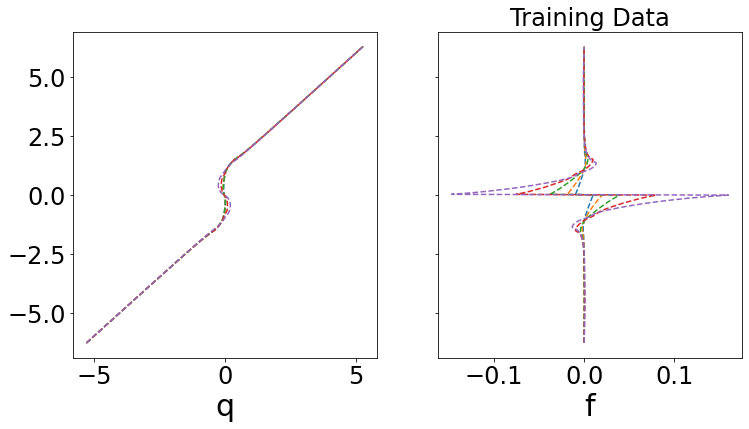

In [2]:
Nx = 384
beta = 1.0
tau_inv = [0.01, 0.02, 0.04, 0.08, 0.16]
N_data = len(tau_inv)

data_dirs = ["../data/beta_1.0_Gamma_1.0_relax_" + str(tau_inv[i]) + "/" for i in range(len(tau_inv))]

L = 4*np.pi
xx, closure_mean,  q_mean, dq_dx_mean = np.zeros((N_data,Nx)), np.zeros((N_data,Nx)), np.zeros((N_data,Nx)), np.zeros((N_data,Nx))
for i in range(N_data):  
    closure_mean[i, :], q_mean[i, :], dq_dx_mean[i, :] = load_data(data_dirs[i])
    xx[i, :] = np.linspace(-L/2.0, L/2.0, Nx)
dx = xx[0, 1] - xx[0, 0]


# TODO: clean data
omega_jet = np.zeros(Nx)
omega_jet[0:Nx//2] = 1.0
omega_jet[Nx//2:Nx] = -1.0
q_jet = omega_jet + beta*xx[0, :]


f = np.zeros(q_mean.shape)

chop_l = 50
for i in range(N_data):  
    q_mean[i, 0:chop_l] = np.linspace(q_jet[0],   q_mean[i,chop_l-1],  chop_l)   #q_jet[0:chop_l]
    q_mean[i, -chop_l:] = np.linspace(q_mean[i, -chop_l], q_jet[-1],  chop_l)   #q_jet[-chop_l:]
    
    
    dq_dx_mean[i, 0:chop_l] = np.linspace(beta, dq_dx_mean[i,chop_l-1],  chop_l)
    dq_dx_mean[i, -chop_l:] = np.linspace(dq_dx_mean[i, -chop_l], beta, chop_l)
    
    closure_mean[i, 0:chop_l] = np.linspace(0.0, closure_mean[i,chop_l-1],  chop_l)
    closure_mean[i, -chop_l:] = np.linspace(closure_mean[i, -chop_l], 0.0, chop_l)
    
    
    
    
    f[i, :] = tau_inv[i]*(q_jet - q_mean[i, :])

q_mean_abs = np.fabs(q_mean)
mu_f = closure_mean/dq_dx_mean
# visualize data

fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, figsize=(12,6))
for i in range(N_data):
    ax[0].plot(q_mean[i, :], xx[i,:],  "--", fillstyle="none", color="C"+str(i))
    ax[1].plot(f[i, :], xx[i,:],  "--", fillstyle="none", color="C"+str(i))
    
ax[0].set_xlabel("q")
ax[1].set_xlabel("f")   
plt.title("Training Data")
plt.savefig("Point-Jet-Training-Data.png")




# Training Loss : || d(D dq/dx)/dx + f(x)|| on the quadratic function

In [3]:
def loss_aug(s_param, params):
    xx, q = s_param.xx, s_param.q
    ind, outd, width = s_param.ind, s_param.outd, s_param.width
    activation, initializer, outputlayer = s_param.activation, s_param.initializer, s_param.outputlayer
    
    N_data, Nx = q.shape
    # does not include top and bottom nodes
    res = np.zeros((N_data, Nx - 2))
    
    
    net =  NeuralNet.create_net(ind, outd, layers, width, activation, initializer, outputlayer,  params)
    nn_model = partial(NeuralNet.nn_viscosity, net=net, mu_scale = mu_scale, non_negative=non_negative, filter_on=filter_on, filter_sigma=filter_sigma)
    
    for i in range(N_data):
        nummodel(nn_model, q[i, :], xx[i, :], res[i, :])
        
    return np.hstack((-np.reshape(res, -1), params))


## Start UKI

In [4]:
class PointJetParam:
    def __init__(self, xx, q, N_y, ind, outd, layers, width, activation, initializer, outputlayer):
        self.theta_names = ["hyperparameters"]
        self.xx = xx
        self.q  = q
        self.ind  = ind
        self.outd = outd
        self.width = width
        self.activation = activation
        self.initializer = initializer
        self.outputlayer = outputlayer
        
        
        N_theta = ind*width + (layers - 2)*width**2 + width*outd + (layers - 1)*width + outd if layers > 1 else ind*outd + outd
        
        self.N_theta = N_theta
        
        
        self.N_y = N_y + N_theta 

In [5]:
y = np.reshape(f[:, 1:Nx - 1], -1)
Sigma_eta = np.fabs(f[:, 1:Nx - 1])
for i in range(N_data):
    Sigma_eta[i, :] = np.mean(Sigma_eta[i, :])
Sigma_eta = np.diag(np.reshape((Sigma_eta*0.01)**2, -1))


N_y = len(y)
s_param = PointJetParam(xx, q_mean, N_y,  ind, outd, layers, width, activation, initializer, outputlayer)


N_theta = s_param.N_theta


theta0_mean_init = NeuralNet.FNN(ind, outd, layers, width, activation, initializer, outputlayer).get_params()
# theta0_mean_init = torch.load("visc.model").get_params()
theta0_mean = np.zeros(N_theta)

theta0_cov = np.zeros((N_theta, N_theta))
np.fill_diagonal(theta0_cov, 100.0**2)  
theta0_cov_init = np.zeros((N_theta, N_theta))
np.fill_diagonal(theta0_cov_init, 0.1**2)  


y_aug = np.hstack((y, theta0_mean))
Sigma_eta_aug = block_diag(Sigma_eta, theta0_cov)


alpha_reg = 1.0
update_freq = 1
N_iter = 10
gamma = 1.0


save_folder = "indirect_NN_res"
uki_obj = KalmanInversion.UKI_Run(s_param, loss_aug, 
    theta0_mean, theta0_mean_init, 
    theta0_cov,  theta0_cov_init, 
    y_aug, Sigma_eta_aug,
    alpha_reg,
    gamma,
    update_freq, 
    N_iter,
    save_folder = save_folder)

ukiobj.gamma :  1.0
optimization error at iter  0  =  1635361969977.4019
data-misfit :  1635361969969.487 reg :  7.914590012139202
Frobenius norm of the covariance at iter  0  =  6.4031242374328485
ukiobj.gamma :  1.0
optimization error at iter  1  =  52907364862.13112
data-misfit :  52907364854.163086 reg :  7.968025850984935
Frobenius norm of the covariance at iter  1  =  6.037053069329852
ukiobj.gamma :  1.0
optimization error at iter  2  =  7902777868.174497
data-misfit :  7902777859.963604 reg :  8.210892880658118
Frobenius norm of the covariance at iter  2  =  7.626383642460212
ukiobj.gamma :  0.5
optimization error at iter  3  =  30070584651890.965
data-misfit :  30070584651880.297 reg :  10.662636471078372
Frobenius norm of the covariance at iter  3  =  10.699981284914783
ukiobj.gamma :  0.5
optimization error at iter  4  =  3872998920405.929
data-misfit :  3872998920400.922 reg :  5.007532862571237
Frobenius norm of the covariance at iter  4  =  13.684977291657308
ukiobj.gamma